In [28]:
import scipy.io
import scipy.ndimage
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy import sparse
from scipy.linalg import block_diag
import pickle
import matplotlib as mpl

import matplotlib.pyplot as plt
from timeit import default_timer
import torch
from functools import partial




from Solver import *


import sys
sys.path.append('../Utility')
import PlotDefault
import NeuralNet
import KalmanInversion 
from Numerics import interpolate_f2c, gradient_first_f2c

# Reference quadratic function
 $$D(\theta) = \sqrt{\theta^2 + (\frac{\partial \theta}{\partial x})^2}$$

In [ ]:
xx, f, q, q_c, dq_c = generate_data()

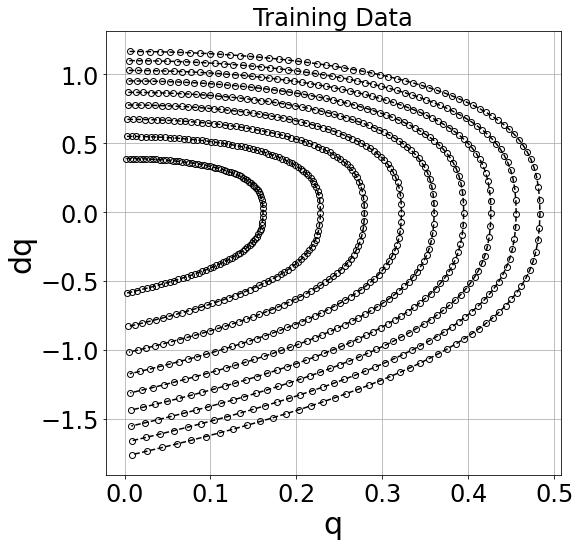

In [56]:
n_data = q_c.shape[0]
plt.figure(figsize=(8,8))
for i in range(n_data):
    plt.plot(q_c[i, :], dq_c[i, :],  "--o", color = "black", fillstyle="none")

plt.grid("on")
plt.xlabel("q")
plt.ylabel("dq")
plt.title("Training Data")

    
plt.subplots_adjust(bottom=0.15,top=0.92,left=0.18,right=0.97)
plt.savefig("Poisson-Training-Data.pdf")

# Load network from indirect training

In [34]:
TRAINING_TYPE = "indirect" # indirect   indirect_res

if TRAINING_TYPE == "direct":
    trained_net = torch.load("direct.nn")
else:
    (save_folder, uki_iter) = ("indirect_NN" , 7) if TRAINING_TYPE=="indirect" else ("indirect_NN_res" , 1)
 
    uki_obj = pickle.load( open( save_folder + "/ukiobj-" + str(uki_iter) + ".dat", "rb" ) )
    trained_net = NeuralNet.create_net(ind, outd, layers, width, activation, initializer, outputlayer, uki_obj.theta_mean[-1])




print(trained_net.modus['LinM{}'.format(1)].weight)
print(trained_net.modus['LinM{}'.format(1)].bias)
print(trained_net.modus['LinMout'].weight)
print(trained_net.modus['LinMout'].bias)

Parameter containing:
tensor([[ 0.9631, -2.3583],
        [-0.8414,  0.0309],
        [-1.1556,  0.1631],
        [ 1.6591,  1.2746],
        [ 1.0637, -3.4808],
        [ 0.9444,  0.1860],
        [-3.3921, -0.2555],
        [-2.2139, -0.1494],
        [-2.1878,  0.6574],
        [-2.5882, -0.1782]], requires_grad=True)
Parameter containing:
tensor([ 1.2277,  2.6526,  2.5163,  1.6085, -1.2715,  2.3797,  3.8185,  2.0989,
         0.6560,  3.3963], requires_grad=True)
Parameter containing:
tensor([[-1.2645,  0.8330,  0.9304, -1.2698,  0.3413,  2.0531, -0.9497,  0.1997,
         -0.7981, -0.7024]], requires_grad=True)
Parameter containing:
tensor([0.5132], requires_grad=True)


# Direct test

/tmp/ipykernel_35975/160397815.py:31: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_35975/160397815.py:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
/tmp/ipykernel_35975/160397815.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated si

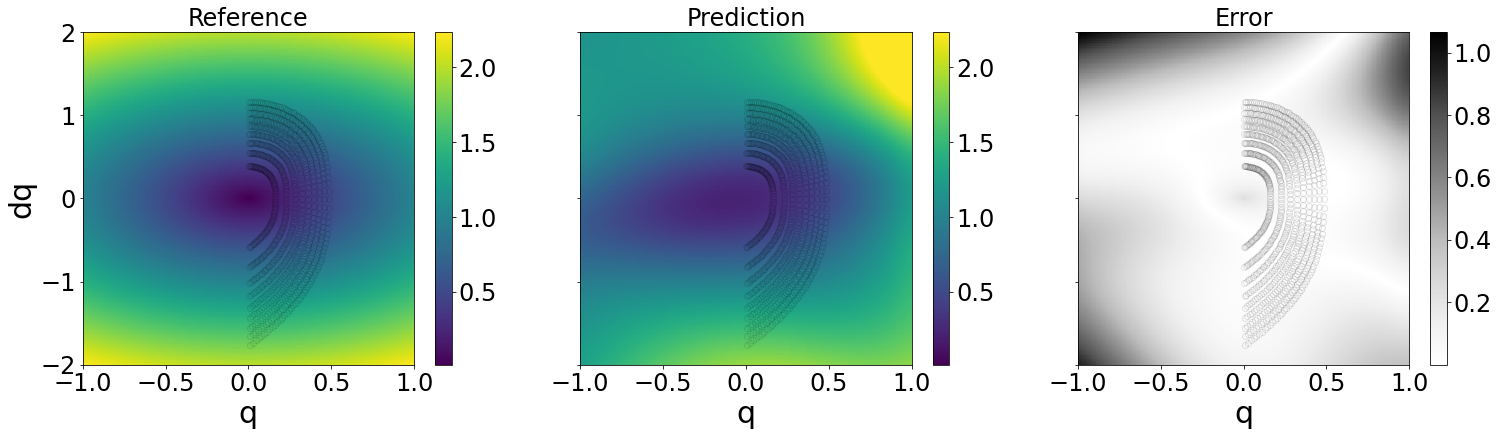

In [49]:
N_test_1d = 200
Lx_test_1d = 1.0
Ly_test_1d = 2.0
N_test = N_test_1d**2

x1_test_1d = np.linspace(-Lx_test_1d, Lx_test_1d, N_test_1d)
x2_test_1d = np.linspace(-Ly_test_1d, Ly_test_1d, N_test_1d)
X_test_2d, Y_test_2d = np.meshgrid(x1_test_1d, x2_test_1d)

x_test = np.vstack((X_test_2d.reshape(-1), Y_test_2d.reshape(-1))).T    
y_test = permeability_ref(x_test).reshape((N_test, 1))


y_pred = NeuralNet.net_eval(net=trained_net, x=x_test, mu_scale=mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma, n_data=N_test_1d)  

y_test_2d = y_test.reshape((N_test_1d,N_test_1d))
y_pred_2d = y_pred.reshape((N_test_1d,N_test_1d))


fig, ax = plt.subplots(ncols=3, sharey=True, nrows=1, figsize=((22,6)))

for j in range(3):
    for i in range(n_data):
        ax[j].plot(q_c[i, :], dq_c[i, :],  "o", color = "black", fillstyle="none", alpha=0.1)
        ax[j].set_xlabel("q")
        if j == 0:
            ax[j].set_ylabel("dq")
        
        
vmin, vmax = y_test_2d.min(), y_test_2d.max()
im0=ax[0].pcolormesh(X_test_2d, Y_test_2d, y_test_2d, vmin=vmin, vmax=vmax)
fig.colorbar(im0, ax=ax[0])
ax[0].set_title("Reference")

im1=ax[1].pcolormesh(X_test_2d, Y_test_2d, y_pred_2d, vmin=vmin, vmax=vmax)
fig.colorbar(im1, ax=ax[1])
ax[1].set_title("Prediction")

im2=ax[2].pcolormesh(X_test_2d, Y_test_2d, np.abs(y_test_2d - y_pred_2d), cmap = "Greys")
fig.colorbar(im2, ax=ax[2])
ax[2].set_title("Error")


    
fig.subplots_adjust(bottom=0.15,top=0.92,left=0.08,right=0.97)
fig.savefig("Poisson-Training-" + TRAINING_TYPE + "-Direct-Test.pdf")



# Plug-in test

100000 max q 0.38380414098810156
200000 max q 0.383879221159854
300000 max q 0.38387922651141576
400000 max q 0.38387922651153894
500000 max q 0.38387922651153894
Last step increment is :  0.0  last step is :  2.698857075128386
100000 max q 0.38362239381742835
200000 max q 0.3837244880815846
300000 max q 0.3837244937668427
400000 max q 0.3837244937506781
500000 max q 0.38372449375065654
Last step increment is :  2.1836427006143763e-10  last step is :  2.7122290195853935
100000 max q 0.5298444646948456
200000 max q 0.5298574719709566
300000 max q 0.5298574721656208
400000 max q 0.5298574721656208
500000 max q 0.5298574721656208
Last step increment is :  0.0  last step is :  3.3879190373440613
100000 max q 0.5312785236070758
200000 max q 0.5312947458492089
300000 max q 0.5312947461511631
400000 max q 0.531294746150126
500000 max q 0.5312947461501953
Last step increment is :  5.059282346968757e-10  last step is :  3.416387329692986
100000 max q 0.23817591147248918
200000 max q 0.238175911

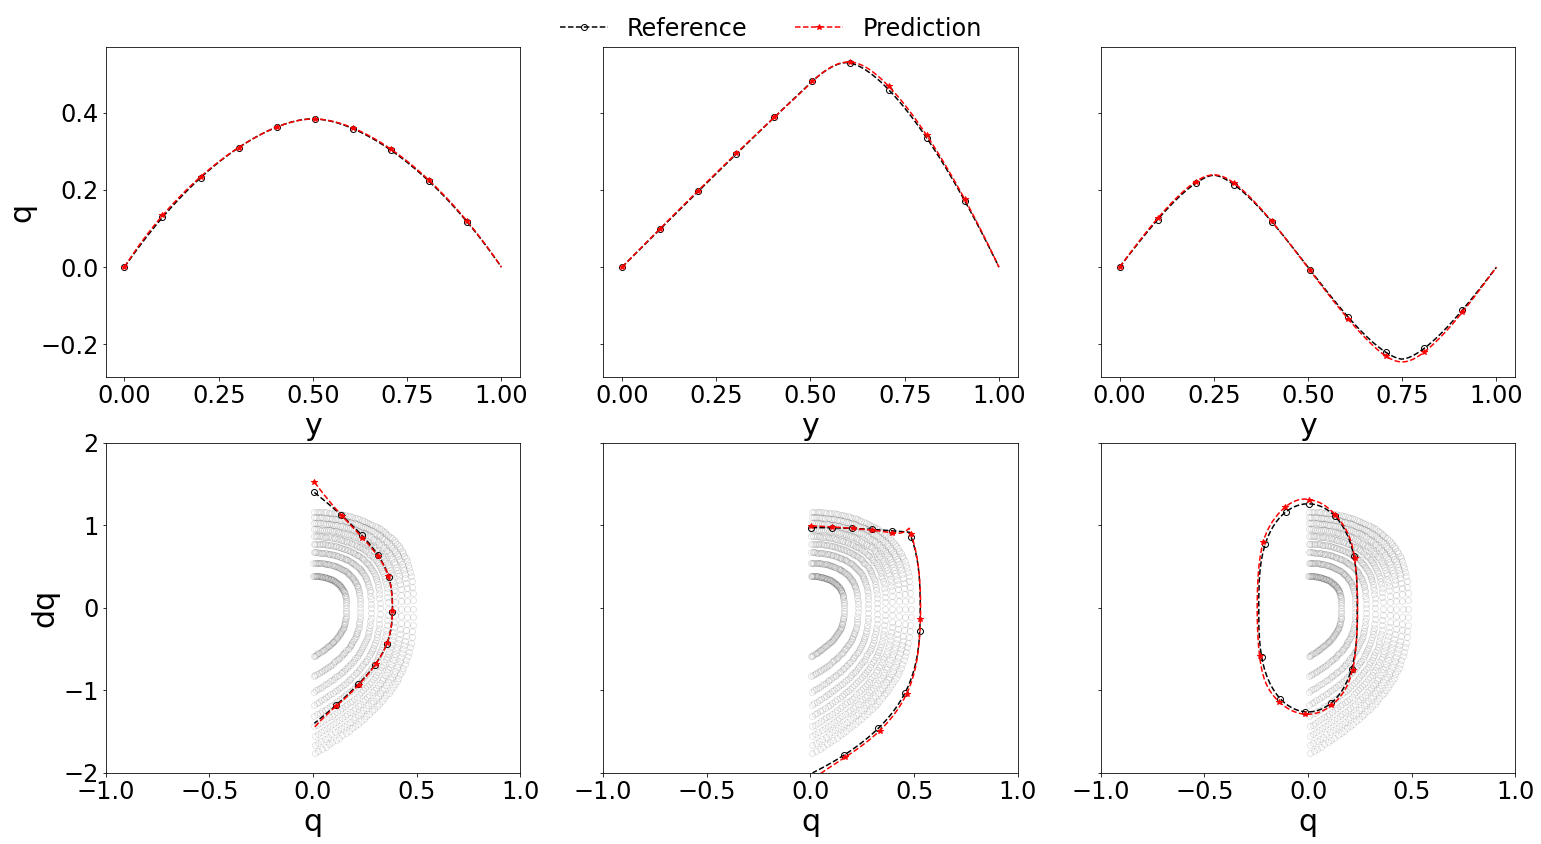

In [46]:
fig, ax = plt.subplots(ncols=3, nrows=2, sharey="row", figsize=((22,12)))



        

def f_func1(xx_test):
    return 6*(1-2*xx_test)**2 - 2*(xx_test - xx_test**2)*(1 - 2*xx_test)**2 + 2*(xx_test - xx_test**2)**2 + 2


def f_func2(xx_test):
    
    f = np.ones_like(xx_test)
    f[xx_test <= 0.5] = 0.0
    f[xx_test > 0.5] = 10.0
    return f


def f_func3(xx_test):
    L = 1
    return 10*np.sin(2*np.pi*xx_test/L)

f_funcs = [f_func1, f_func2, f_func3]

for i in range(3):
    
    f_func = f_funcs[i]
    xx, f, q_ref, q_c_ref, dq_c_ref  = generate_data_helper(permeability_ref, f_func, L=1.0, Nx = 100)
    nn_model = partial(NeuralNet.nn_viscosity, net=trained_net, mu_scale = mu_scale, non_negative=non_negative, filter_on=filter_on, filter_sigma=filter_sigma)
    _, _, q_pred, q_c_pred, dq_c_pred  = generate_data_helper(nn_model, f_func, L=1.0, Nx = 100)
    
    

    ax[0,i].plot(xx, q_ref,  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
    ax[0,i].plot(xx, q_pred,  "--*", color="red", label="Prediction", markevery=10)
    if i == 0:
        ax[0,i].set_ylabel("q")
    ax[0,i].set_xlabel("y")
    
    for j in range(n_data):
        ax[1,i].plot(q_c[j, :], dq_c[j, :],  "o", color = "black", fillstyle="none", alpha=0.1)
        
    ax[1,i].plot(q_c_ref, dq_c_ref,  "--o", color="black", fillstyle="none", label="Reference", markevery=10)
    ax[1,i].plot(q_c_pred, dq_c_pred,  "--*", color="red", label="Prediction", markevery=10)
    ax[1,i].set_xlim([-1,1])
    ax[1,i].set_ylim([-2,2])
    if i == 0:
        ax[1,i].set_ylabel("dq")
    ax[1,i].set_xlabel("q")
    
    
    
    

    
handles, labels = ax[0,0].get_legend_handles_labels()
fig.subplots_adjust(bottom=0.08,top=0.92,left=0.08,right=0.97)
fig.legend(handles,labels,loc = "upper center",bbox_to_anchor=(0.5,0.98),ncol=2,frameon=False)

fig.savefig("Poisson-Training-" + TRAINING_TYPE + "-Indirect-Test.pdf")
